In [ ]:
!pip3 install numpy pandas matplotlib

In [2]:
# Create a new conda environment with the following command:
# conda create -n bench python=3 pandas seaborn matplotlib numpy
# conda activate bench

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import rcParams
from matplotlib import rcParamsDefault
import numpy as np
from matplotlib.colors import ListedColormap

figure_save = False
figure_fmt = 'pdf'
path_suffix = '-baseline'
rcParams.update({'figure.autolayout': True})
cmap = plt.get_cmap('cividis')
lower_limit = 0.0
upper_limit = 0.85
new_cmap = cmap(np.linspace(lower_limit, upper_limit, cmap.N))
# increase the red by 5%
new_cmap = new_cmap[::-1]
new_cmap = ListedColormap(new_cmap)

yir_mans_nice_fonts = {
    "axes.labelsize": 14,
    "legend.fontsize": 60,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
}

# rcParams.update(rcParamsDefault)
rcParams.update(yir_mans_nice_fonts)
# rc reset


# Figure 14

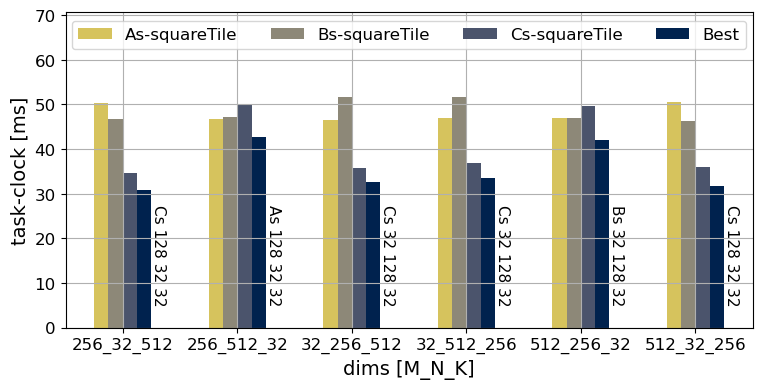

In [3]:
rcParams.update({'figure.autolayout': True})
file_path = '../ex2_pynq/results/results-latest.csv'
rows = []
with open(file_path, 'r') as f:
    for line in f:
        rows.append(line.split(','))


df = pd.DataFrame.from_records(rows)
df = df.iloc[:, 0:13]
df = df.drop(columns=[11])
df.columns = ['prob_id','sol', 'dims', 'kernel', 'tool', 'accel_size',
              'accel_version', 'strategy', 'threads', 'board', 'value', 'metric']
df['accel_size'] = df['accel_size'].astype(int)
df['prob_id'] = df['prob_id'].astype(int)
df['dims'] = df['dims']
df['sol'] = df['sol']
df['value'] = pd.to_numeric(df['value'], errors='coerce')
df1 = df
df = df.drop(columns=['strategy'])
df = df.drop(columns=['threads'])
df = df.drop(columns=['prob_id'])

def filter_df(df, filter_dict):
    """Filter the df based on dictionary key pairs"""
    filter = []
    for key, value in filter_dict.items():
        filter.append(df[key] == value)
    filter = np.array(filter).all(axis=0)
    return df[filter]

all_columns = df.columns
filter_dict = {}
filter_dict['metric'] = 'task-clock'
filtered_df = filter_df(df, filter_dict)
filtered_df = filtered_df[filtered_df.accel_size >= 8]


to_plot = ['value']
pv_columns = ['sol']
pv_index = [x for x in all_columns if x not in pv_columns + to_plot]
df_pivot = filtered_df.pivot_table(
    index=pv_index, columns=pv_columns, values=to_plot)
df_dropped = df_pivot
# Check if len of uniques in a index is 1 and drop it if it is
for col in df_dropped.index.names:
    if len(df_dropped.index.get_level_values(col).unique()) == 1:
        df_dropped = df_dropped.droplevel(col)


df_to_plot = df_dropped

ax = df_to_plot.plot(kind='bar', figsize=(8, 4), logy=False, rot=0, cmap=new_cmap)
ax.set_ylabel("task-clock [ms]")
ax.set_xlabel("dims [M_N_K]")
ax.grid()
plt.title("Performance of different strategies for different problem sizes")
plt.title("")
plt.xticks(rotation=0, ha='center')
ymin,ymax = ax.get_ylim()
plt.ylim(0.0, ymax*1.3)
handles, labels = ax.get_legend_handles_labels()
for i in range(0,len(labels)):
    labels[i] = labels[i].replace("(value, ","")
    labels[i] = labels[i].replace(")","")

labels = ['As-squareTile', 'Bs-squareTile', 'Cs-squareTile', 'Best']
ax.legend(handles[0:], labels,loc="best",fontsize=12)
ax.legend(handles[0:], labels,loc="upper center",ncol=4,fontsize=12)
c=0
extra=["Cs_128_32_32","As_128_32_32","Cs_32_128_32","Cs_32_128_32","Bs_32_128_32","Cs_128_32_32"]
for id,p in enumerate(ax.patches):
    if id>17:
        if p.get_height()>5:
            k = extra[c].replace("_"," ")
            ax.annotate(k, (p.get_x() + p.get_width() / 1, 10),
                ha='left', va='center', fontsize=11, color='k', xytext=(0, 20),
                textcoords='offset points',rotation=270)
            c+=1
                            
if figure_save:
    plt.savefig("./output/MM_permutations_v4.pdf", format=figure_fmt)
plt.show()